![](https://static.tacdn.com/img2/brand_refresh/application_icons/post-image-550x370.png)
# Predict TripAdvisor Rating
### В этом соревновании мы предскажем рейтинги ресторанов в TripAdvisor

## Import

In [125]:
import pandas as pd
import numpy as np

import re
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
        
import datetime
from datetime import datetime, timedelta

In [126]:
# Фиксируем RANDOM_SEED, чтобы нашии эксперименты были воспроизводимы:
RANDOM_SEED = 42

In [127]:
# Фиксируем версию пакетов, чтобы наши эксперименты были воспроизводимы:
!pip freeze > requirements.txt

## Data

In [128]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

Посмотрим на количественные характеристики наших признаков:

In [129]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [130]:
df_train.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [131]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [132]:
df_test.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


ВАЖНО! Для корректной обработки признаков объединяем train и test в один датасет:

In [236]:
df_train['sample'] = 1 # помечаем, где у нас train;
df_test['sample'] = 0 # помечаем, где у нас test;
df_test['Rating'] = 0 # в test у нас нет значения Rating, мы его должны предсказать, поэтому пока просто заполняем нулями.

data = df_test.append(df_train, sort=False).reset_index(drop=True)

Посмотрим на данные:

In [134]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
39319,id_911,Rome,"['Italian', 'Mediterranean', 'Vegetarian Frien...",912.0,$,372.0,"[['Great restaurant', 'My best dinner in Rome'...",/Restaurant_Review-g187791-d2441917-Reviews-Os...,d2441917,1,4.0
27918,id_6680,London,"['Cafe', 'Vegetarian Friendly']",6689.0,$,39.0,"[['Tongue Tantalising', 'Lovely fresh salads']...",/Restaurant_Review-g186338-d6167537-Reviews-Le...,d6167537,1,4.0
10816,id_2228,Prague,['Cafe'],2233.0,$$ - $$$,11.0,"[['TERRIBLE STAFF', 'Nice change'], ['04/29/20...",/Restaurant_Review-g274707-d10412920-Reviews-C...,d10412920,1,4.0
24012,id_11390,London,"['Bar', 'Pub', 'Italian', 'Mediterranean']",11400.0,$$ - $$$,15.0,"[['Great pub and great beers!', 'Bella!'], ['0...",/Restaurant_Review-g186338-d4366865-Reviews-La...,d4366865,1,3.5
27625,id_3155,London,"['Bar', 'British', 'Pub', 'Vegetarian Friendly']",3161.0,$$ - $$$,158.0,"[['Great pub', 'Nice place, good food'], ['12/...",/Restaurant_Review-g186338-d3308333-Reviews-Th...,d3308333,1,4.0


In [135]:
data.shape

(50000, 11)

In [136]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


#### Признаки датасета:

- Restaurant_id — идентификационный номер ресторана;
- City — город, в котором находится ресторан;
- Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
- Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
- Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
- Price Range — диапазон цен в ресторане;
- Number of Reviews — количество отзывов о ресторане;
- Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
- URL_TA — URL страницы ресторана на TripAdvisor;
- ID_TA — идентификатор ресторана в базе данных TripAdvisor.


Приведем названия признаков к общему виду, для более удобной работы:

In [137]:
data.columns = ['_'.join(col.split()).lower() for col in data.columns]

Посмотрим на уникальность данных:

In [138]:
data.nunique()

restaurant_id        13094
city                    31
cuisine_style        10731
ranking              12975
price_range              3
number_of_reviews     1573
reviews              41857
url_ta               49963
id_ta                49963
sample                   2
rating                  10
dtype: int64

Как видно, такие признаки как restaurant_id, utl_ta, id_ta, которые якобы должны быть уникальными, имеют дубли.
Возможные причины:

- ошибки в данных, например, если датасет собирался из разных источников;
- ресторан является сетевым и под одним id находится несколько филиалов в разных локациях.

Как видим, большинство признаков у нас требует очистки и предварительной обработки

In [139]:
data.reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

# Data Preparation
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения любой реальной задачи.
![](https://www.aramar.co.uk/getmedia/115f9d70-637f-4b9a-9385-560fb542d8c9/data-analytics.png.aspx?ext=.png&width=500)

In [140]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      50000 non-null  object 
 1   city               50000 non-null  object 
 2   cuisine_style      38410 non-null  object 
 3   ranking            50000 non-null  float64
 4   price_range        32639 non-null  object 
 5   number_of_reviews  46800 non-null  float64
 6   reviews            49998 non-null  object 
 7   url_ta             50000 non-null  object 
 8   id_ta              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


## 1. NAN Values Processing
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора данных. 
С пропусками нужно быть внимательными, так как **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN будем выносить информацию о наличии пропусков, как отдельный признак.

### 1.1. cuisine_style 

Создадим булевый признак, где 0 - пропуск, 1 - истинное значение:

In [141]:
data['cuisine_style_NAN'] = pd.isna(data['cuisine_style']).astype('uint8')

Пропуски в cuisine_style заменим на Other:

In [142]:
data.cuisine_style = data.cuisine_style.fillna("['Other']")

Видим, что направление Other является самым встречаемым в датасете:

In [143]:
data.cuisine_style.value_counts()

['Other']                                                                                                 11590
['Italian']                                                                                                1332
['French']                                                                                                 1019
['Spanish']                                                                                                 860
['French', 'European']                                                                                      503
                                                                                                          ...  
['Mediterranean', 'European', 'Spanish', 'Delicatessen', 'Vegetarian Friendly', 'Gluten Free Options']        1
['Italian', 'Bar', 'Mediterranean', 'Pub']                                                                    1
['Mediterranean', 'Spanish', 'International', 'Contemporary', 'Vegetarian Friendly']                    

In [144]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      50000 non-null  object 
 1   city               50000 non-null  object 
 2   cuisine_style      50000 non-null  object 
 3   ranking            50000 non-null  float64
 4   price_range        32639 non-null  object 
 5   number_of_reviews  46800 non-null  float64
 6   reviews            49998 non-null  object 
 7   url_ta             50000 non-null  object 
 8   id_ta              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  rating             50000 non-null  float64
 11  cuisine_style_NAN  50000 non-null  uint8  
dtypes: float64(3), int64(1), object(7), uint8(1)
memory usage: 4.2+ MB


### 1.2. price_range

Посмотрим на частотность распределения значений признака price_range:

In [145]:
data.price_range.value_counts(ascending=False)

$$ - $$$    23041
$            7816
$$$$         1782
Name: price_range, dtype: int64

Для начала создадим булевый признак, где 0 - пропуск, 1 - истинное значение:

In [146]:
data['price_range_NAN'] = pd.isna(data['price_range']).astype('uint8')

Видим, что значение среднего уровня цен более, чем в 3 раза выше остальных.
Заполним пропуски средним значением. Далее оценим, как это скажется на качестве модели.

In [147]:
data.price_range = data.price_range.fillna(value='$$ - $$$')

In [148]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      50000 non-null  object 
 1   city               50000 non-null  object 
 2   cuisine_style      50000 non-null  object 
 3   ranking            50000 non-null  float64
 4   price_range        50000 non-null  object 
 5   number_of_reviews  46800 non-null  float64
 6   reviews            49998 non-null  object 
 7   url_ta             50000 non-null  object 
 8   id_ta              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  rating             50000 non-null  float64
 11  cuisine_style_NAN  50000 non-null  uint8  
 12  price_range_NAN    50000 non-null  uint8  
dtypes: float64(3), int64(1), object(7), uint8(2)
memory usage: 4.3+ MB


### 1.3. number_of_reviews

Cоздадим булевый признак, где 0 - пропуск, 1 - истинное значение:

In [149]:
data['number_of_reviews_NAN'] = pd.isna(data['number_of_reviews']).astype('uint8')

Заполним пропуски средним значением по городу.
Для этого посчитаем среднее количество отзывов по городам:

In [150]:
mean_num_rev = data.groupby('city').number_of_reviews.mean()

data.number_of_reviews = data.apply(lambda row: mean_num_rev[row['city']] 
                                    if pd.isnull(row['number_of_reviews']) \
                                    else row['number_of_reviews'], axis=1)

In [151]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   restaurant_id          50000 non-null  object 
 1   city                   50000 non-null  object 
 2   cuisine_style          50000 non-null  object 
 3   ranking                50000 non-null  float64
 4   price_range            50000 non-null  object 
 5   number_of_reviews      50000 non-null  float64
 6   reviews                49998 non-null  object 
 7   url_ta                 50000 non-null  object 
 8   id_ta                  50000 non-null  object 
 9   sample                 50000 non-null  int64  
 10  rating                 50000 non-null  float64
 11  cuisine_style_NAN      50000 non-null  uint8  
 12  price_range_NAN        50000 non-null  uint8  
 13  number_of_reviews_NAN  50000 non-null  uint8  
dtypes: float64(3), int64(1), object(7), uint8(3)
memory us

### 1.4. reviews

Посмотрим на частотность признака:

In [152]:
data.reviews.value_counts()

[[], []]                                                                                                                   8112
[['Nice restaurant in Madrid', 'Highly reccomended'], ['11/10/2017', '05/21/2017']]                                           2
[['Simply Excellent!', 'Modern!'], ['10/22/2017', '08/29/2017']]                                                              2
[['Happened to drop in', 'Right for a quick bite'], ['11/30/2016', '06/20/2015']]                                             2
[['Visited the rooftop bar', 'SIXTH FLOOR ROOFTOP BUT YOU CAN ONLY SEE O...'], ['06/27/2017', '10/31/2017']]                  2
                                                                                                                           ... 
[['Loved it- will return !!', 'Best family restaurant in D6'], ['10/20/2017', '09/28/2017']]                                  1
[['Macarons!', 'Amazing Chocolate and Desserts'], ['11/04/2017', '09/02/2017']]                         

Видим, что 8112 строк в признаке reviews имеют пустые значения [[], []]. Заменим их на np.nan:

In [153]:
data.reviews = data.reviews.apply(lambda string: np.nan if string == '[[], []]' else string)

Cоздадим булевый признак, где 0 - пропуск, 1 - истинное значение:

In [154]:
data['reviews_NAN'] = pd.isna(data['reviews']).astype('uint8')

In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   restaurant_id          50000 non-null  object 
 1   city                   50000 non-null  object 
 2   cuisine_style          50000 non-null  object 
 3   ranking                50000 non-null  float64
 4   price_range            50000 non-null  object 
 5   number_of_reviews      50000 non-null  float64
 6   reviews                41886 non-null  object 
 7   url_ta                 50000 non-null  object 
 8   id_ta                  50000 non-null  object 
 9   sample                 50000 non-null  int64  
 10  rating                 50000 non-null  float64
 11  cuisine_style_NAN      50000 non-null  uint8  
 12  price_range_NAN        50000 non-null  uint8  
 13  number_of_reviews_NAN  50000 non-null  uint8  
 14  reviews_NAN            50000 non-null  uint8  
dtypes:

## 2. Feature Engineering
Генерация признаков – пожалуй, самый творческий этап подготовки данных для машинного обучения.

![](https://user92966.clients-cdnnow.ru/upload/setka-editor/338/338b842ace08dc71b1d85f1436556ba6.png?15760576722437793)

In [156]:
data.sample(5)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,cuisine_style_NAN,price_range_NAN,number_of_reviews_NAN,reviews_NAN
34821,id_1403,Barcelona,"['Spanish', 'Mediterranean', 'European']",1404.0,$,75.000000,"[['Good little fine!', 'Nice and friendly'], [...",/Restaurant_Review-g187497-d11743900-Reviews-T...,d11743900,1,4.0,0,0,0,0
6332,id_6332,Stockholm,['Other'],2424.0,$$ - $$$,75.197479,"[['Poor ramen noodle soup'], ['11/30/2017']]",/Restaurant_Review-g189852-d13205700-Reviews-N...,d13205700,0,0.0,1,1,1,0
22438,id_6308,Paris,"['Mexican', 'Latin', 'Central American', 'Vege...",6309.0,$$ - $$$,230.000000,[['Nice atmosphere. OK food. Expensive drin......,/Restaurant_Review-g187147-d718705-Reviews-La_...,d718705,1,3.5,0,0,0,0
10010,id_6578,Barcelona,['Other'],6579.0,$$ - $$$,6.000000,NaN,/Restaurant_Review-g187497-d10696479-Reviews-R...,d10696479,1,3.0,1,1,0,1
22743,id_2802,Berlin,['Other'],2804.0,$$ - $$$,19.000000,"[['Small place n tasty food', 'Classic Donner'...",/Restaurant_Review-g187323-d1341422-Reviews-Bo...,d1341422,1,4.5,1,1,0,0


### 2.1. restaurant_id, chain_restaurant

Посмотрим на уникальность значений этого признака (помним, что общее число 50000):

In [157]:
data.restaurant_id.nunique()

13094

Видим, что некоторые id повторяются. Делаем вывод, что в датасете также присутствуют данные сетевых ресторанов:

In [158]:
data.restaurant_id.value_counts()

id_227      19
id_871      19
id_436      19
id_633      19
id_585      18
            ..
id_10171     1
id_12050     1
id_11967     1
id_9460      1
id_11593     1
Name: restaurant_id, Length: 13094, dtype: int64

Создадим список сетевых ресторанов:

In [159]:
chain_lst = list(data.restaurant_id.value_counts()[data.restaurant_id.value_counts() > 1].index)

Теперь создадим новый признак для наших ресторанов, который будет обозначать принадлежность к сети: 1 - да, 0 - нет:

In [160]:
data['chain_restaurant'] = data[data.restaurant_id.isin(chain_lst)].restaurant_id.apply(lambda x: 1)
data['chain_restaurant'].fillna(0, inplace=True)

Видим, что подавляющее большинство ресторанов являются частью сетевого бизнеса:

In [161]:
data.chain_restaurant.value_counts()

1.0    46193
0.0     3807
Name: chain_restaurant, dtype: int64

### 2.2. city, city_population, capital, rest_count, dummy variables of city
> Признак city - кладезь ценной информации, так как в общем доступе мы можем найти данные по статусу городов, их географическим особенностям, населении и другим параметрам. Теперь рассмотрим данные поближе и подумаем, что нам понадобится.

В этом признаке содержится 31 уникаьлное значение - сравнительно немного:

In [162]:
data.city.nunique()

31

Видим, что в списке представлены крупные европейские города, многие из которых являются ещё и столицами:

In [163]:
data.city.value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: city, dtype: int64

Поменяем название португальского Порто на интернациональное - Porto:

In [164]:
data.replace({'city': {'Oporto':'Porto'}}, inplace=True)

Благодаря гистограмме наглядно видно, что в тройку самых развитых городов с точки зрения ресторанного бизнеса входят Лондон, Париж и Мадрид:

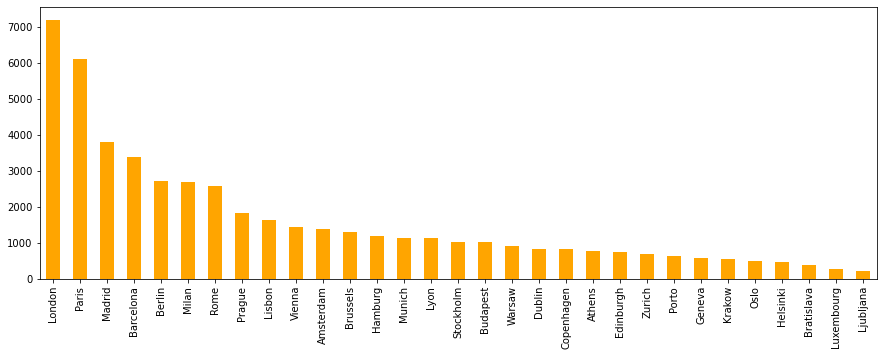

In [165]:
plt.figure(figsize=(15,5))
data.city.value_counts(ascending=False).plot(kind='bar', color='orange')

Добавим в наш датасет информацию о населении в каждом рассматриваемом городе. Данные берём за 2018 год (так как остальные данные именно 2018 года) на портале: https://worldpopulationreview.com

In [166]:
city_population_dict = {
            'London': 9046485,
            'Paris': 10900952,
            'Madrid': 6497124,
            'Barcelona': 5494125,
            'Berlin': 3552123, 
            'Milan': 3132060,
            'Rome': 4209710,
            'Prague': 1291552,
            'Lisbon': 2927316,
            'Vienna': 1900547,
            'Amsterdam': 1131690,
            'Brussels': 2049510,
            'Hamburg': 1792904,
            'Munich': 1503708,
            'Lyon': 1690105,
            'Stockholm': 1582968,
            'Budapest': 1759497,
            'Warsaw': 1767798,
            'Dublin': 1201426,
            'Copenhagen': 1320826,
            'Athens': 3155600,
            'Edinburgh': 524639,
            'Zurich': 1370779,
            'Porto': 1306934,
            'Geneva': 599376,
            'Krakow': 767178,
            'Oslo': 1012225,
            'Helsinki': 1279096,
            'Bratislava': 429920,
            'Luxembourg': 115227,
            'Ljubljana': 288307
 }

Обращаем внимание на вполне логичную пропорциональность - чем гуще населён город, тем больше ресторанов (+/-). 
Создаём новый признак:

In [167]:
data['city_population'] = data['city'].map(city_population_dict)

Также создадим новый признак, который будет указывать, являетлся ли город столицей (1 - да, 0 - нет):

In [168]:
capitals_lst = ['London', 'Paris', 'Madrid', 'Berlin', 'Rome', 'Prague', 'Lisbon', 'Vienna', 'Amsterdam', 
                'Brussels', 'Stockholm','Budapest', 'Warsaw', 'Dublin', 'Copenhagen', 'Athens', 
                'Edinburgh', 'Oslo', 'Helsinki', 'Bratislava', 'Luxemburg', 'Ljubljana']

data['capital'] = data['city'].apply(lambda x: 1 if x in capitals_lst else 0)

Теперь создадим новый признак rest_count, который будет содержать инфо о количестве ресторанов в том или ином городе:

In [169]:
rest_count_dict = dict(data['city'].value_counts())
data['rest_count'] = data['city'].map(rest_count_dict)

Создадим на всякий случай дубль признака city перед созданием dummy переменных:

In [170]:
data['city1'] = data.city

Признак city категориальный, поэтому преобразуем его в числовой формат с помощью метода One-Hot Encoding средствами Python:

In [171]:
data = pd.get_dummies(data,columns=['city'], dummy_na=True)

Удаляем столбец city_nan, так как он имеет только нулевые значения:

In [172]:
data.drop(['city_nan'], axis='columns', inplace=True)

In [173]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   restaurant_id          50000 non-null  object 
 1   cuisine_style          50000 non-null  object 
 2   ranking                50000 non-null  float64
 3   price_range            50000 non-null  object 
 4   number_of_reviews      50000 non-null  float64
 5   reviews                41886 non-null  object 
 6   url_ta                 50000 non-null  object 
 7   id_ta                  50000 non-null  object 
 8   sample                 50000 non-null  int64  
 9   rating                 50000 non-null  float64
 10  cuisine_style_NAN      50000 non-null  uint8  
 11  price_range_NAN        50000 non-null  uint8  
 12  number_of_reviews_NAN  50000 non-null  uint8  
 13  reviews_NAN            50000 non-null  uint8  
 14  chain_restaurant       50000 non-null  float64
 15  ci

### 2.3. cuisine_style, cuisine_count, unique_cuisine, dummy variables of cuisine_style

Посмотрим поближе на содержание переменной cuisine_style:

In [174]:
data.cuisine_style[1]

"['European', 'Scandinavian', 'Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options']"

Данные имеют строковый тип:

In [175]:
type(data.cuisine_style[1])

str

Переведем тип str в list:

In [176]:
data.cuisine_style = data.cuisine_style.apply(lambda x: x.split(",") if type(x) == str else x)

Уберём лишние символы:

In [177]:
for lst in data.cuisine_style:
    if type(lst) == list:
        for i in range(len(lst)):
            lst[i] = lst[i].replace("[", "").strip()
            lst[i] = lst[i].replace("'", "").strip()
            lst[i] = lst[i].replace("]", "").strip()            
print(data.cuisine_style[4])

['Italian', 'Mediterranean', 'European', 'Seafood', 'Vegetarian Friendly', 'Gluten Free Options']


Создадим признак cuisine_count - количество кухонь, предлагаемых в ресторане:

In [178]:
data['cuisine_count'] = data.cuisine_style.apply(lambda x: len(x) if type(x) == list else x)

Посмотрим на распределение нового признака:

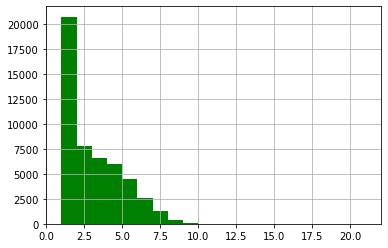

In [179]:
data.cuisine_count.hist(bins=20, color='green')

Создадим список кухонь по всем ресторанам:

In [180]:
cuisine_lst = []

for lst in data.cuisine_style:
    if type(lst) == list:
        for el in lst:
            cuisine_lst.append(el)

Видим, что кухни направлений Vegetarian Friendly и European лидируют, а Salvadoran и Xinjiang замыкают список:

In [181]:
pd.Series(cuisine_lst).value_counts()

Vegetarian Friendly    14021
European               12561
Other                  11590
Mediterranean           7820
Italian                 7433
                       ...  
Polynesian                 2
Latvian                    1
Salvadoran                 1
Burmese                    1
Xinjiang                   1
Length: 126, dtype: int64

Для дальнейшего обучения модели оставим только 60 самых популярных кухонь:

In [182]:
top_cuis = set(pd.Series(cuisine_lst).value_counts().head(60).index.to_list())
print('Популярные кухни:', top_cuis)

Популярные кухни: {'Bar', 'Chinese', 'American', 'British', 'Vietnamese', 'Scandinavian', 'Mexican', 'Czech', 'Delicatessen', 'Cafe', 'Sushi', 'French', 'International', 'Italian', 'Healthy', 'Fusion', 'Seafood', 'Swedish', 'Thai', 'Vegetarian Friendly', 'Central European', 'Greek', 'Wine Bar', 'German', 'Gluten Free Options', 'Contemporary', 'Asian', 'Halal', 'Indian', 'Irish', 'Belgian', 'Street Food', 'Eastern European', 'Danish', 'Japanese', 'Fast Food', 'Vegan Options', 'Spanish', 'Mediterranean', 'Gastropub', 'Hungarian', 'Steakhouse', 'European', 'Portuguese', 'Barbecue', 'Grill', 'Other', 'Brew Pub', 'Latin', 'Pub', 'Polish', 'Dutch', 'Lebanese', 'Diner', 'Austrian', 'South American', 'Soups', 'Middle Eastern', 'Pizza', 'Turkish'}


Кухни, встречающиеся меньше 50 раз, будем считать редкими. Их всего 42:

In [183]:
unigue_cuis_lst = data.explode('cuisine_style')['cuisine_style'].value_counts()[
    data.explode('cuisine_style')['cuisine_style'].value_counts() < 50].index.tolist()
print('Редкие кухни:', unigue_cuis_lst)

Редкие кухни: ['Malaysian', 'Jamaican', 'Australian', 'Croatian', 'Cuban', 'Taiwanese', 'Colombian', 'Sri Lankan', 'Tibetan', 'Cajun & Creole', 'Afghani', 'Southwestern', 'Egyptian', 'Tunisian', 'Hawaiian', 'Cambodian', 'Singaporean', 'Mongolian', 'Ukrainian', 'Georgian', 'Armenian', 'Filipino', 'Chilean', 'Romanian', 'Minority Chinese', 'Central Asian', 'Ecuadorean', 'Albanian', 'New Zealand', 'Canadian', 'Native American', 'Uzbek', 'Caucasian', 'Azerbaijani', 'Welsh', 'Yunnan', 'Fujian', 'Polynesian', 'Latvian', 'Salvadoran', 'Burmese', 'Xinjiang']


Напишем функцию для подсчёта редких кухонь в ресторанах:

In [184]:
def unigue_cuis_count(cell):
    x = 0
    for i in unigue_cuis_lst:
        if i in cell:
            x += 1
    return x

Создадим признак, в который поместим количество редких кухонь в том или ином ресторане:

In [185]:
data['unique_cuisine'] = data['cuisine_style'].apply(unigue_cuis_count)
data['unique_cuisine'].value_counts()

0    49347
1      619
2       31
3        3
Name: unique_cuisine, dtype: int64

Признак cuisine_style категориальный, поэтому преобразуем его в числовой формат с помощью метода One-Hot Encoding (как писали выше, используем только 60 самых популярных кухонь):

In [186]:
def find_item(cell):
    if item in cell:
        return 1
    return 0
    
for item in top_cuis:
    data[item] = data['cuisine_style'].apply(find_item)

### 2.3. ranking, ranking_norm

ranking показывает место, которое занимает ресторан среди всех остальных в своём городе. Это важный признак, один из немногих, оказывающих непосредственное влияние на целевую переменную.

In [187]:
df_train.loc[:, ["Ranking", "Rating"]].corr()

,Ranking,Rating
Ranking,1.000000,-0.368371
Rating,-0.368371,1.000000


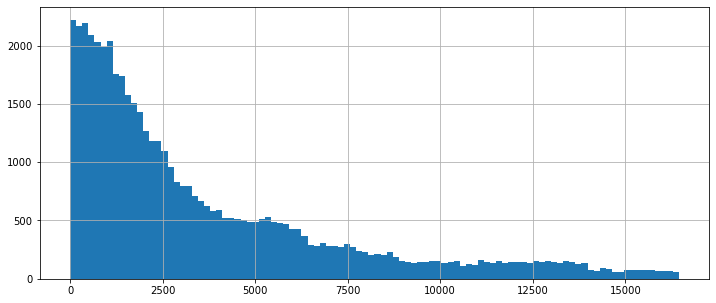

In [188]:
plt.rcParams['figure.figsize'] = (12,5)
data['ranking'].hist(bins=100);

Посмотрим на ранг ресторанов по 10 самым крупным городам:  

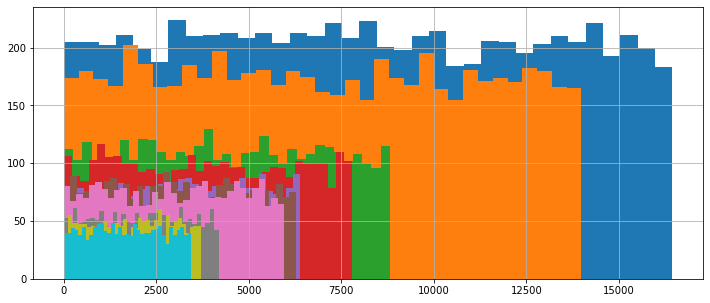

In [189]:
for x in (data['city1'].value_counts())[0:10].index:
    data['ranking'][data['city1'] == x].hist(bins=35)

Признак ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за этого мы имеем смещение.

Создадим признак ranking_norm, который будет обозначать относительный ранг ресторана по городу:

In [190]:
data['ranking_norm'] = data['ranking'] / data['rest_count']

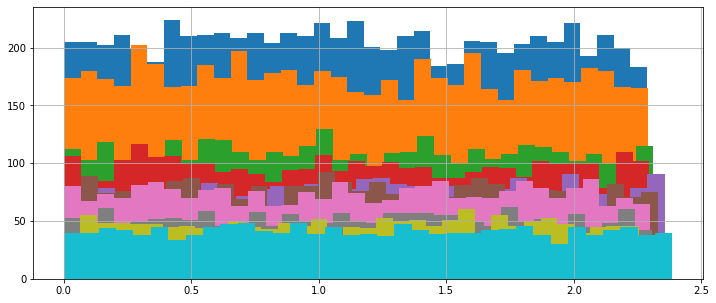

In [191]:
for x in (data['city1'].value_counts())[0:10].index:
    data['ranking_norm'][data['city1'] == x].hist(bins=35)

Проверим кореляцию нового признака с другими (больше 0.3):

In [192]:
corr_matrix_new = data[data["sample"] == 1].corr()
corr_matrix_new[abs(corr_matrix_new.ranking) > 0.3].ranking_norm

ranking                0.557146
rating                -0.543724
chain_restaurant      -0.300930
city_population       -0.017965
rest_count            -0.017035
city_London           -0.010144
city_Paris            -0.011878
cuisine_count         -0.540847
Vegetarian Friendly   -0.548918
ranking_norm           1.000000
Name: ranking_norm, dtype: float64

Видим, что новая переменная ranking_norm хорошо скоррелирована с такими параметрами, как number_of_reviews, rating, chain_restaraunt, cuisine_count. Это позволяет сделать нам несколько ценных исайтов: 
- чем больше отзывов о ресторане, тем выше его ранг,
- у сетевых ресторанов довольно высокий ранг (возможно, за счёт популярности),
- количество кухонь больше в ресторанах с более высоким рангом, 
- чем выше рейтинг ресторана, тем выше его ранг (что вполне логично).


### 2.4. price_range

In [193]:
data.price_range.value_counts()

$$ - $$$    40402
$            7816
$$$$         1782
Name: price_range, dtype: int64

Преобразуем значения, обозначающий диапазон цен, с формата $ на числовой по принципу Label Encoding:

In [194]:
data.replace({'price_range': {'$':1, '$$ - $$$':2, '$$$$':3}}, inplace=True)

Теперь обозначения следующие: 1 - низкие, 2 - средние, 3 - высокие цены в ресторанах:

In [195]:
data.price_range.value_counts()

2    40402
1     7816
3     1782
Name: price_range, dtype: int64

Делаем ценный инсайт - самые дорогие рестораны (3) реже получают низкие оценки:

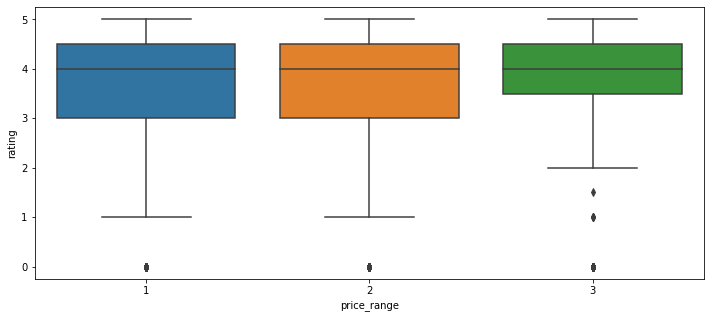

In [196]:
sns.boxplot(x='price_range', y='rating', data=data)

### 2.5. reviews, date_1, date_2, review_days, days_to_last_rev_1, days_to_last_rev_2

Каждый отзыв состоит из двух последних отзывов и двух дат их написания, соответственно:

In [197]:
data.reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

При этом тип данных - строчный:

In [198]:
type(data.reviews[1])

str

Переведем тип str в list:

In [199]:
data.reviews = data.reviews.apply(lambda x: x.split(",") if type(x) == str else x)

Уберём лишние символы:

In [200]:
for lst in data.reviews:
    if type(lst) == list:
        for i in range(len(lst)):
            lst[i] = lst[i].replace("[", "").strip()
            lst[i] = lst[i].replace("'", "").strip()
            lst[i] = lst[i].replace("]", "").strip()            
print(data.reviews[2])

['Better than the Links', 'Ivy Black', '12/28/2017', '12/06/2017']


Создадим новые признаки: date_1 / date_2:

In [201]:
data['date_1'] = data['reviews'].dropna().apply(lambda x: x[-2])
data['date_2'] = data['reviews'].dropna().apply(lambda x: x[-1])

И обновим reviews, удалив из него даты:

In [202]:
data['reviews'] = data['reviews'].dropna().apply(lambda x: x[:2])

Переводим наши признаки с датами в формат datetime:

In [203]:
data['date_1'] = pd.to_datetime(data['date_1'], errors='coerce')
data['date_2'] = pd.to_datetime(data['date_2'], errors='coerce')

Заменим пропуски в date_1 и date_2 на самые часто встречающиеся даты соответственно:

In [204]:
data['date_1'].fillna(data.date_1.value_counts().index[0], inplace=True)
data['date_2'].fillna(data.date_2.value_counts().index[0], inplace=True)

Cоздадим признак review_days, который будет содержать разницу между последними двумя отзывами в днях:

In [205]:
data['review_days'] = abs(data['date_2'] - data['date_1']).dt.days

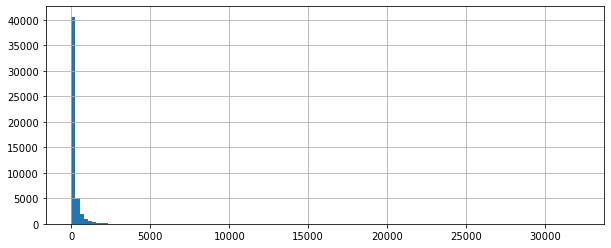

In [206]:
plt.figure(figsize=(10,4))
data['review_days'].hist(bins=125)

Создадим признаки, обозначающие разницу между максимальной датой и остальными датами для date_1 и date_2. Это поможет проанализировать, какие интервалы частотности написания отзывов сформировались:

In [207]:
data['days_to_last_rev_1'] = (data.date_1.max() - data.date_1).dt.days
data['days_to_last_rev_2'] = (data.date_2.max() - data.date_2).dt.days

### 2.6. number_of_reviews, num_reviews_city, rank_rev_city

Посмотрим на распределение признака number_of_reviews относительно городов. Чем больше ресторанов, тем больше отзывов:

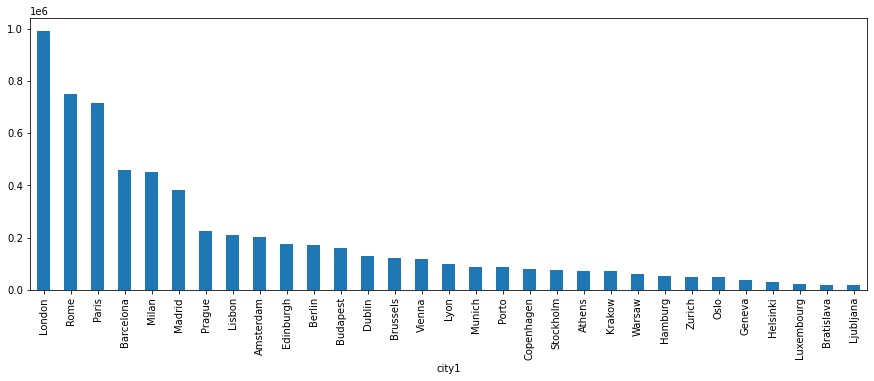

In [208]:
plt.figure(figsize=(15,5))
data.groupby('city1')['number_of_reviews'].sum().sort_values(ascending=False).plot(kind='bar')

Создадим переменную num_reviews_city, в которую добавим общее количество отзывов, ранжируя их по городам:

In [209]:
rewiews_city_dict = dict(data.groupby('city1')['number_of_reviews'].sum())
data['num_reviews_city'] = round(data.city1.map(rewiews_city_dict), 0)

Создадим признак rank_rev_city - отношение ранга ресторана к количеству отзывов в городе:

In [210]:
data['rank_rev_city'] = data['ranking'] / data['num_reviews_city']

## Subtotal
Признаки url_ta и id_ta удалим, так как на данном этапе не хватает знаний для их обработки. 

По итогу, в дополнение к первоначальным признакам мы добавили:
- **chain_restaurant** -  признак принадлежности ресторана к сети,
- **city_population** -  население города,
- **capital** - является ли город столицей, 
- **rest_count** -  количество ресторанов в городе,
- **dummy переменные** признака **city**, всего 31,
- **cuisine_count** - количество кухонь, предлагаемых в ресторане, 
- **unigue_cuis_lst** - количество редких кухонь, 
- **dummy переменные** признака **cuisine_style**, всего 60,
- **ranking_norm** - относительный ранг ресторана по городу,
- **date 1 / date 2** - признаки, обозначающие первую и вторую дату двух отзывов, соответственно,
- **review_days** - разница между двумя отзывами,
- **days_to_last_rev_1 / days_to_last_rev_2** - разницы между максимальной датой и остальными датами для date 1 / date 2,
- **num_reviews_city** - общее количество отзывов, ранжированное по городам, 
- **rank_rev_city** - отношение ранга ресторана к количеству отзывов в городе.

In [211]:
data.drop(['url_ta'], axis='columns', inplace=True)
data.drop(['id_ta'], axis='columns', inplace=True)

Также удалим категориальные признаки, обработанные ранее - restaurant_id, cuisine_style, city1, reviews. Они нам больше не понадобятся:

In [212]:
data.drop(['restaurant_id'], axis='columns', inplace=True)
data.drop(['cuisine_style'], axis='columns', inplace=True)
data.drop(['city1'], axis='columns', inplace=True)
data.drop(['reviews'], axis='columns', inplace=True)
data.drop(['date_1'], axis='columns', inplace=True)
data.drop(['date_2'], axis='columns', inplace=True)

In [213]:
data

,ranking,price_range,number_of_reviews,sample,rating,cuisine_style_NAN,price_range_NAN,number_of_reviews_NAN,reviews_NAN,chain_restaurant,...,Soups,Middle Eastern,Pizza,Turkish,ranking_norm,review_days,days_to_last_rev_1,days_to_last_rev_2,num_reviews_city,rank_rev_city
0,12963.0,2,4.0,0,0.0,0,0,0,1,1.0,...,0,0,0,0,2.122299,4,50,54,714886.0,0.018133
1,106.0,2,97.0,0,0.0,0,0,0,0,1.0,...,0,0,0,0,0.223158,37,83,120,31360.0,0.003380
2,810.0,2,28.0,0,0.0,0,0,0,0,1.0,...,0,0,0,0,1.087248,22,60,82,177095.0,0.004574
3,1669.0,3,202.0,0,0.0,0,0,0,0,1.0,...,0,0,0,0,0.232031,14,82,96,992407.0,0.001682
4,37.0,3,162.0,0,0.0,0,0,0,0,1.0,...,0,0,0,0,0.097368,15,18,33,19614.0,0.001886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,500.0,2,79.0,1,4.5,0,0,0,0,1.0,...,0,0,0,0,0.185598,34,72,106,453397.0,0.001103
49996,6341.0,2,542.0,1,3.5,0,0,0,0,1.0,...,0,0,0,0,1.038147,9,67,76,714886.0,0.008870
49997,1652.0,2,4.0,1,4.5,0,1,0,0,1.0,...,0,0,0,0,1.599226,3127,480,3607,77679.0,0.021267
49998,641.0,2,70.0,1,4.0,0,0,0,0,1.0,...,0,0,0,0,0.692973,23,230,253,62079.0,0.010326


In [214]:
data.sample(5)

,ranking,price_range,number_of_reviews,sample,rating,cuisine_style_NAN,price_range_NAN,number_of_reviews_NAN,reviews_NAN,chain_restaurant,...,Soups,Middle Eastern,Pizza,Turkish,ranking_norm,review_days,days_to_last_rev_1,days_to_last_rev_2,num_reviews_city,rank_rev_city
45308,674.0,2,142.0,1,4.0,0,0,0,0,1.0,...,0,0,0,0,0.660137,69,106,175,162012.0,0.004160
31598,13456.0,2,7.0,1,4.0,1,1,0,0,1.0,...,0,0,0,0,1.870708,87,715,802,992407.0,0.013559
25477,781.0,2,11.0,1,4.5,0,0,0,1,1.0,...,0,0,0,0,0.693606,4,50,54,98044.0,0.007966
37072,4432.0,2,34.0,1,4.5,1,1,0,0,1.0,...,0,0,0,0,0.725606,780,50,830,714886.0,0.006200
11626,866.0,2,8.0,1,5.0,0,0,0,0,1.0,...,0,0,0,0,0.848188,41,101,142,162012.0,0.005345


In [215]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 112 entries, ranking to rank_rev_city
dtypes: float64(7), int64(70), uint8(35)
memory usage: 31.0 MB


# EDA

### Посмотрим распределение признака Ranking:

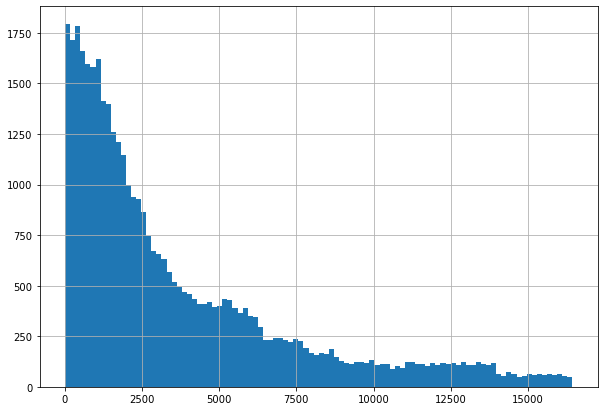

In [216]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

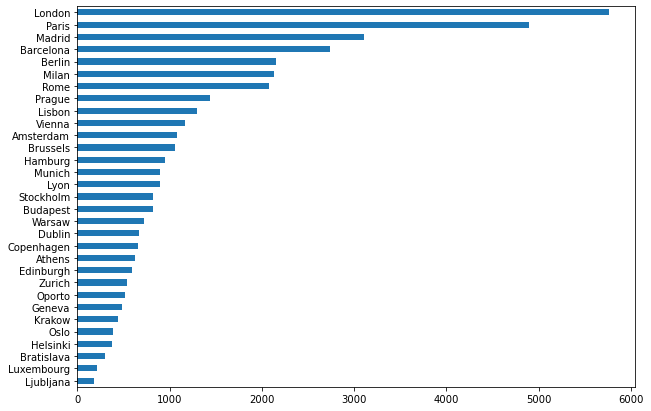

In [217]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

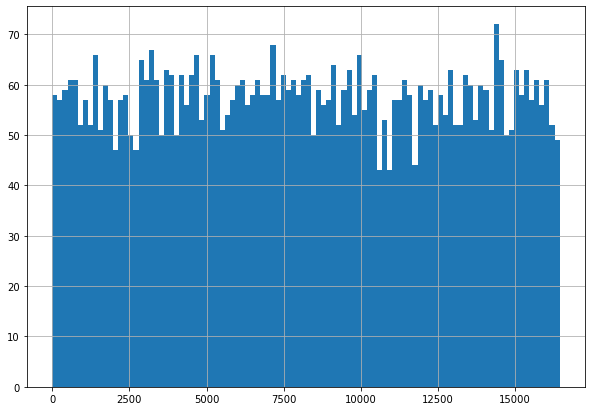

In [218]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

Посмотрим на топ 10 городов:

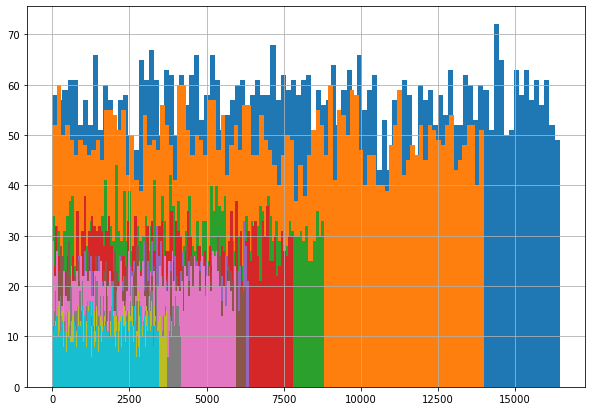

In [219]:
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

### Посмотрим распределение целевой переменной Rating:

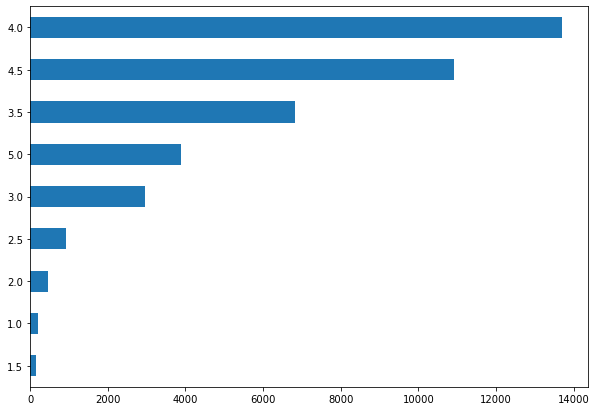

In [220]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной Rating относительно признака Ranking:

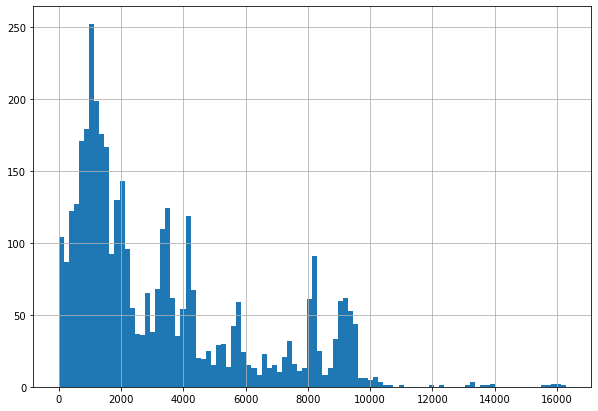

In [221]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

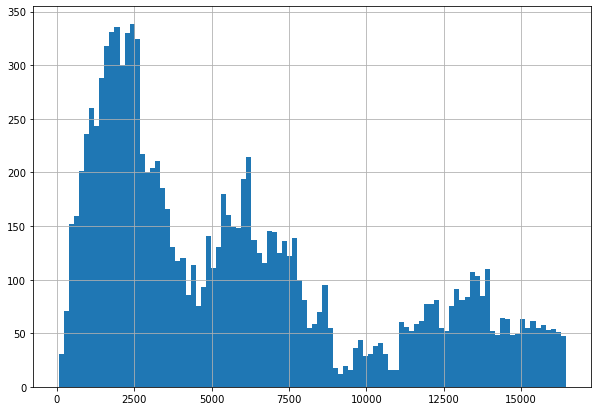

In [222]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

## Correlation
На этом графике уже сейчас мы сможетем заметить, как признаки связаны между собой и с целевой переменной:

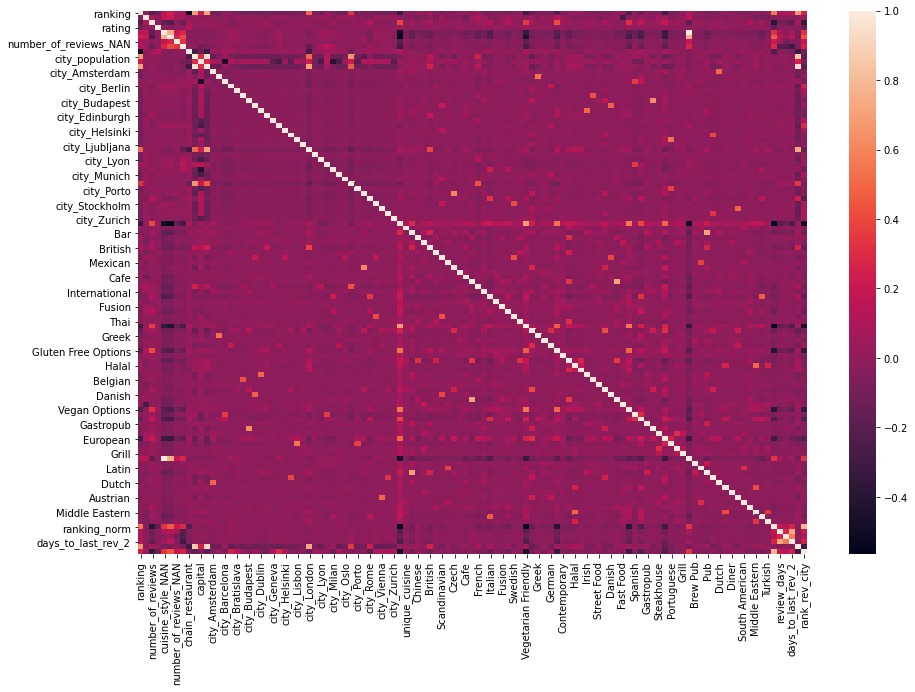

In [223]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

# Data Preprocessing

In [235]:
df_preproc = data.copy(deep=True)
df_preproc.head(10)

,ranking,price_range,number_of_reviews,sample,rating,cuisine_style_NAN,price_range_NAN,number_of_reviews_NAN,reviews_NAN,chain_restaurant,...,Soups,Middle Eastern,Pizza,Turkish,ranking_norm,review_days,days_to_last_rev_1,days_to_last_rev_2,num_reviews_city,rank_rev_city
0,12963.0,2,4.000000,0,0.0,0,0,0,1,1.0,...,0,0,0,0,2.122299,4,50,54,714886.0,0.018133
1,106.0,2,97.000000,0,0.0,0,0,0,0,1.0,...,0,0,0,0,0.223158,37,83,120,31360.0,0.003380
2,810.0,2,28.000000,0,0.0,0,0,0,0,1.0,...,0,0,0,0,1.087248,22,60,82,177095.0,0.004574
3,1669.0,3,202.000000,0,0.0,0,0,0,0,1.0,...,0,0,0,0,0.232031,14,82,96,992407.0,0.001682
4,37.0,3,162.000000,0,0.0,0,0,0,0,1.0,...,0,0,0,0,0.097368,15,18,33,19614.0,0.001886
5,5093.0,1,24.000000,0,0.0,0,0,0,0,1.0,...,0,0,0,0,0.833824,5,172,177,714886.0,0.007124
6,3704.0,1,2.000000,0,0.0,0,0,0,1,1.0,...,0,0,0,0,2.248937,4,50,54,210536.0,0.017593
7,2330.0,2,158.680214,0,0.0,1,1,1,1,1.0,...,0,0,0,0,2.282076,4,50,54,162012.0,0.014382
8,771.0,2,2.000000,0,0.0,0,1,0,0,1.0,...,0,0,0,0,1.623158,88,50,138,31360.0,0.024585
9,605.0,2,13.000000,0,0.0,0,1,0,0,1.0,...,0,0,0,0,0.585673,34,86,120,77679.0,0.007788


Теперь выделим тестовую часть

In [226]:
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

Воспользуемся специальной функцие train_test_split для разбивки тестовых данных выделим 20% данных на валидацию (параметр test_size)

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Проверяем:

In [228]:
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 111), (40000, 111), (40000, 110), (32000, 110), (8000, 110))

# Model 
Сам ML

Импортируем необходимые библиотеки:

In [229]:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ):

In [230]:
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

Обучаем модель на тестовом наборе данных

In [282]:
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred_1 = model.predict(X_test)
y_pred = np.around(y_pred_1*2, decimals=0) / 2

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются.
Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.

In [283]:
MAE = 'MAE:', metrics.mean_absolute_error(y_test, y_pred)
MAE

('MAE:', 0.164625)

В RandomForestRegressor есть возможность вывести самые важные признаки для модели

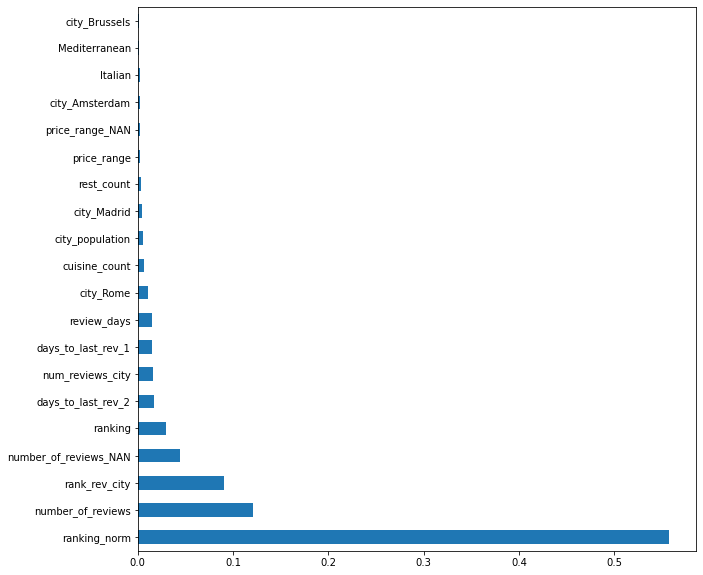

In [287]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# Total

Итак, на данном этапе показатель метрики МАЕ нашей модели составляет: 

In [285]:
MAE

('MAE:', 0.164625)